<a href="https://colab.research.google.com/github/njmathai/IntroML/blob/master/Tutorial_Backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Backpropagation

Agenda:
1. Introduce classification problem
2. Derive backprop equations for a simple neural network
3. Implement backprop equations in code

In [0]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid
import math
%matplotlib inline

## Introducing the toy dataset

We've seen in lecture that a linear classifier is bound to produce errors if our data is not linearly separable. We can avoid this issue by using a more powerful classifier. 

In this tutorial, we examine a classification problem for which the data is not linearly separable. We will instead implement a neural network and train it using gradient descent, computing gradients using the backpropagation algorithm.

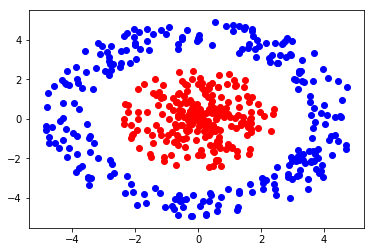

In [0]:
np.random.seed(0)

def make_dataset(num_points):
    radius = 5
    data = []
    labels = []
    # Generate positive examples (labeled 1).
    for i in range(num_points // 2):
        r = np.random.uniform(0, radius*0.5)
        angle = np.random.uniform(0, 2*math.pi)
        x = r * math.sin(angle)
        y = r * math.cos(angle)
        data.append([x, y])
        labels.append(1)
        
    # Generate negative examples (labeled 0).
    for i in range(num_points // 2):
        r = np.random.uniform(radius*0.7, radius)
        angle = np.random.uniform(0, 2*math.pi)
        x = r * math.sin(angle)
        y = r * math.cos(angle)
        data.append([x, y])
        labels.append(0)
        
    data = np.asarray(data)
    labels = np.asarray(labels)
    return data, labels
    
num_data = 500
data, labels = make_dataset(num_data)

# Note: red indicates a label of 1, blue indicates a label of 0
plt.scatter(data[:num_data//2, 0], data[:num_data//2, 1], color='red') 
plt.scatter(data[num_data//2:, 0], data[num_data//2:, 1], color='blue')     

## Neural network definition

We will try to classify this data by training a neural network. As a reminder, our goal is to take as input a two dimensional vector $\mathbf{x} = [x_1, x_2]^T$ and output $\text{Pr}(t = 1 | \mathbf{x})$, where $t$ is the label of the datapoint $\mathbf{x}$. 

We will use a neural network with one hidden layer which has three hidden units. The equations describing our neural network are below:

$$\mathbf{g} = \mathbf{U} \mathbf{x} + \mathbf{b}$$
$$\mathbf{h} = \tanh(\mathbf{g})$$
$$z = \mathbf{W} \mathbf{h} + c$$
$$y = \sigma(z)$$

In the equations above, $\mathbf{U} = \begin{pmatrix} u_{11} & u_{12} \\ u_{21} & u_{22} \\  u_{31} & u_{32} \end{pmatrix} \in \mathbb{R}^{3 \times 2}, \mathbf{b} = \begin{pmatrix} b_1  \\ b_2 \\ b_3 \end{pmatrix} \in \mathbb{R}^3, \mathbf{W} = \begin{pmatrix} w_{1} & w_{2} & w_{3} \end{pmatrix} \in \mathbb{R}^{1 \times 3}, c \in \mathbb{R}$ are the parameters of our neural network which we must learn. Notice we are writing $\mathbf{W}$ as a matrix with one row.



## Vectorizing the neural network

We want our neural network to produce predictions for multiple points efficiently. We can do so by vectorizing over training examples. Let  $\mathbf{X} = \begin{pmatrix} x_{11} & x_{12} \\ \vdots   & \vdots  \\  x_{N1} & x_{N2}
\end{pmatrix}$ be a matrix containing $N$ datapoints in separate rows. Then we can vectorize by using:

$$\mathbf{G} = \mathbf{X}\mathbf{U}^T + \mathbf{1}\mathbf{b}^T$$
$$\mathbf{H} = \tanh(\mathbf{G})$$
$$\mathbf{z} =  \mathbf{H}\mathbf{W}^T + \mathbf{1}c$$
$$\mathbf{y} = \sigma(\mathbf{z})$$

$\mathbf{G}$, for example, will store each of the three hidden unit values for each datapoint in each corresponding row.

We can rewrite in scalar form as:
$$g_{ij} = u_{j1} x_{i1} + u_{j2} x_{i2} + b_j$$
$$h_{ij} = \tanh(g_{ij})$$
$$z_{i} = w_1 h_{i1} + w_2 h_{i2} + w_{3} h_{i3} + c$$
$$y_i = \sigma(z_i)$$
Here, $i$ indexes data points and $j$ indexes hidden units, so $i \in \{1, \dots, N\}$ and $j \in \{1, 2, 3\}$.


In [0]:
# First, initialize our neural network parameters.
params = {}
params['U'] = np.random.randn(3, 2)
params['b'] = np.zeros(3)
params['W'] = np.random.randn(3)
params['c'] = 0

# Notice we make use of numpy's broadcasting when adding the bias b.
def forward(X, params):    
    G = np.dot(X, params['U'].T)  + params['b']
    H = np.tanh(G)
    z = np.dot(H, params['W'].T) + params['c']
    y = sigmoid(z)
    
    return y

## Visualize the network's predictions

Let's visualize the predictions of our untrained network. As we can see, the network does not succeed at classifying the points without training

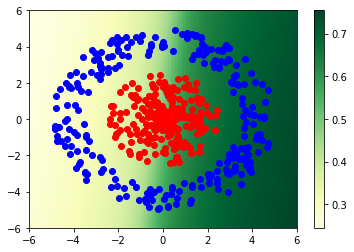

In [0]:
num_points = 200
x1s = np.linspace(-6.0, 6.0, num_points)
x2s = np.linspace(-6.0, 6.0, num_points)

points = np.transpose([np.tile(x1s, len(x2s)), np.repeat(x2s, len(x1s))])
Y = forward(points, params).reshape(num_points, num_points)
X1, X2 = np.meshgrid(x1s, x2s)

plt.pcolormesh(X1, X2, Y, cmap=plt.cm.get_cmap('YlGn'))
plt.colorbar()
plt.scatter(data[:num_data//2, 0], data[:num_data//2, 1], color='red') 
plt.scatter(data[num_data//2:, 0], data[num_data//2:, 1], color='blue') 

## Loss function

We will use the same cross entropy loss function as in logistic regression. This loss function is:

$$\mathcal{L}_{CE}(y, t) = -t \log(y) - (1 - t)\log(1 - y)$$

Here $y = Pr(t = 1|\mathbf{x})$ and $t$ is the true label.

Remember that computing the derivative of this loss function $\frac{d L}{dy}$ can become numerically unstable. Instead, we combine the logistic function and the cross entropy loss into a single function called logistic cross-entropy:

$$\mathcal{L}_{LCE}(z, t) = t \log(1 + \exp(-z)) + (1 -t) \log(1 + \exp(z))$$

See Lecture 4 Notes for review on this. 

Our cost function is the sum over multiple examples of the loss function, normalized by the number of examples:

$$\mathcal{E}(\mathbf{z}, \mathbf{t}) = \frac{1}{N} \left[\sum_{i=1}^N \mathcal{L}(z_i, t_i)\right]$$

## Derive backpropagation equations

We now derive the backpropagation equations in scalar form and then vectorize on the board.


## Implement backpropagation equations

In [0]:
def backprop(X, t, params):
    N = X.shape[0]
    
    # Perform forwards computation.
    G = np.dot(X, params['U'].T)  + params['b']
    H = np.tanh(G)
    z = np.dot(H, params['W'].T) + params['c']
    y = sigmoid(z)
    loss = (1./N) * np.sum(-t * np.log(y) - (1 - t) * np.log(1 - y))
    
    # Perform backwards computation.
    E_bar = 1
    z_bar = (1./N) * (y - t)
    W_bar = np.dot(H.T, z_bar)
    c_bar = np.dot(z_bar, np.ones(N))
    H_bar = np.outer(z_bar, params['W'].T)
    G_bar = H_bar * (1 - np.tanh(G)**2)
    U_bar = np.dot(G_bar.T, X)
    b_bar = np.dot(G_bar.T, np.ones(N))
    
    # Wrap our gradients in a dictionary.
    grads = {}
    grads['U'] = U_bar
    grads['b'] = b_bar
    grads['W'] = W_bar
    grads['c'] = c_bar
    
    return grads, loss

## Training the network

We can train our network parameters using gradient descent once we have computed derivatives using the backpropagation algorithm. Recall that the gradient descent update rule for a given parameter $p$ and a learning rate $\alpha$ is:

$$p \gets p - \alpha * \frac{\partial \mathcal{E}}{\partial p}$$

In [0]:
num_steps = 1000
alpha = 1
for step in range(num_steps):        
    grads, loss = backprop(data, labels, params)
    for k in params:
        params[k] -= alpha * grads[k]

    # Print loss every so often.
    if step % 50 == 0:
        print("Step {:3d} | Loss {:3.2f}".format(step, loss))

Step   0 | Loss 0.75
Step  50 | Loss 0.43
Step 100 | Loss 0.35
Step 150 | Loss 0.16
Step 200 | Loss 0.11
Step 250 | Loss 0.09
Step 300 | Loss 0.07
Step 350 | Loss 0.06
Step 400 | Loss 0.06
Step 450 | Loss 0.05
Step 500 | Loss 0.05
Step 550 | Loss 0.05
Step 600 | Loss 0.04
Step 650 | Loss 0.04
Step 700 | Loss 0.04
Step 750 | Loss 0.04
Step 800 | Loss 0.04
Step 850 | Loss 0.04
Step 900 | Loss 0.04
Step 950 | Loss 0.03


## Visualizing the predictions

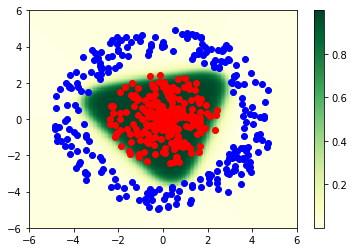

In [0]:
num_points = 200
x1s = np.linspace(-6.0, 6.0, num_points)
x2s = np.linspace(-6.0, 6.0, num_points)

points = np.transpose([np.tile(x1s, len(x2s)), np.repeat(x2s, len(x1s))])
Y = forward(points, params).reshape(num_points, num_points)
X1, X2 = np.meshgrid(x1s, x2s)

plt.pcolormesh(X1, X2, Y, cmap=plt.cm.get_cmap('YlGn'))
plt.colorbar()
plt.scatter(data[:num_data//2, 0], data[:num_data//2, 1], color='red') 
plt.scatter(data[num_data//2:, 0], data[num_data//2:, 1], color='blue') 

## Looking forward: Automatic differentiation

You probably noticed that manually deriving the backpropagation equations is slow and error prone. It becomes even easier to make an error when implementing in code. Luckily, we almost never have to derive the backwards equations by hand. Instead, we make use of automatic differentation software packaged in libraries such as Autograd, PyTorch, and Tensorflow to compute derivatives for us. 